<a href="https://colab.research.google.com/github/Justabhi96/advanced_computer_vision/blob/master/01_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Download Dataset(Fruits 360)

In [0]:
import os
import shutil

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
shutil.copyfile("drive/My Drive/fruits.zip", "fruits.zip")

'fruits.zip'

In [0]:
!unzip -q fruits.zip

In [0]:
def mkdir(dir_path):
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)

def copy_data(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

###Create a small data for training

In [0]:
subset_classes = ["Apple Golden 1", "Avocado", "Lemon", "Mango", "Banana", "Strawberry"]

In [0]:
mkdir("fruits-360_dataset/fruits-360-small")

In [0]:
train_path_from = os.path.abspath('fruits-360_dataset/fruits-360/Training')
valid_path_from = os.path.abspath('fruits-360_dataset/fruits-360/Test')

train_path_to = os.path.abspath('fruits-360_dataset/fruits-360-small/Training')
valid_path_to = os.path.abspath('fruits-360_dataset/fruits-360-small/Test')

In [0]:
mkdir(train_path_to)
mkdir(valid_path_to)

In [0]:
for fruit_class in subset_classes:
  copy_data(f'{train_path_from}/{fruit_class}', f'{train_path_to}/{fruit_class}')
  copy_data(f'{valid_path_from}/{fruit_class}', f'{valid_path_to}/{fruit_class}')

### Transfer Learning using VGG weights

In [0]:
from keras.layers import Dense, Input, Lambda, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [0]:
IMAGE_SIZE = [100, 100]

In [0]:
train_path = train_path_to
test_path = valid_path_to

In [0]:
train_files = glob(train_path+"/*/*.jp*g")
test_files = glob(test_path+"/*/*.jp*g")

classes = glob(train_path+"/*")
train_files[:4]

['/content/fruits-360_dataset/fruits-360-small/Training/Strawberry/127_100.jpg',
 '/content/fruits-360_dataset/fruits-360-small/Training/Strawberry/r_254_100.jpg',
 '/content/fruits-360_dataset/fruits-360-small/Training/Strawberry/123_100.jpg',
 '/content/fruits-360_dataset/fruits-360-small/Training/Strawberry/r_169_100.jpg']

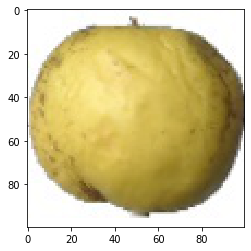

In [0]:
plt.imshow(image.load_img(np.random.choice(train_files)))

In [0]:
vgg = VGG16(input_shape = IMAGE_SIZE+[3], weights = "imagenet", include_top = False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# we can add more layers if we want
x = Flatten()(vgg.output)
x = Dense(1000, activation = "relu")(x)
x = Dense(len(classes), activation = "softmax")(x)

model = Model(inputs = vgg.input, outputs = x)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [0]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [0]:
gen = ImageDataGenerator(rotation_range = 20,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.1,
                         zoom_range = 0.2,
                         horizontal_flip = True,
                         vertical_flip = True,
                         preprocessing_function = preprocess_input)

batch_size = 32
train_gen = gen.flow_from_directory(train_path, 
                                    target_size = IMAGE_SIZE,
                                    shuffle = True,
                                    batch_size = batch_size)
test_gen = gen.flow_from_directory(test_path, 
                                    target_size = IMAGE_SIZE,
                                    shuffle = True,
                                    batch_size = batch_size)

Found 2883 images belonging to 6 classes.
Found 967 images belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -102.481224 max: 151.061


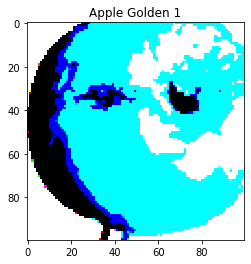

In [0]:
# let's see one of the preprocessed image
# images loogs strange since VGG weights are BGR
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(subset_classes[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [0]:
r = model.fit_generator(train_gen, validation_data=test_gen,
                        epochs = 5,
                        steps_per_epoch = len(train_files)//batch_size,
                        validation_steps = len(test_files)//batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
90/90 [==============================] - 17s 192ms/step - loss: 4.5011 - acc: 0.6968 - val_loss: 2.7814 - val_acc: 0.8240
Epoch 2/5
90/90 [==============================] - 11s 119ms/step - loss: 2.8833 - acc: 0.8156 - val_loss: 2.6400 - val_acc: 0.8353
Epoch 3/5
90/90 [==============================] - 11s 119ms/step - loss: 2.7866 - acc: 0.8241 - val_loss: 2.9298 - val_acc: 0.8096
Epoch 4/5
90/90 [==============================] - 11s 118ms/step - loss: 2.8681 - acc: 0.8190 - val_loss: 2.7477 - val_acc: 0.8289
Epoch 5/5
90/90 [==============================] - 10s 116ms/step - loss: 2.6723 - acc: 0.8326 - val_loss: 2.7111 - val_acc: 0.8299


In [0]:
# with one extra dense layer with 1000 neurons
r1 = model.fit_generator(train_gen, validation_data=test_gen,
                        epochs = 5,
                        steps_per_epoch = len(train_files)//batch_size,
                        validation_steps = len(test_files)//batch_size)

Epoch 1/5
90/90 [==============================] - 11s 126ms/step - loss: 5.8187 - acc: 0.6357 - val_loss: 5.5379 - val_acc: 0.6562
Epoch 2/5
90/90 [==============================] - 11s 120ms/step - loss: 5.4708 - acc: 0.6598 - val_loss: 5.4306 - val_acc: 0.6631
Epoch 3/5
90/90 [==============================] - 11s 120ms/step - loss: 3.6917 - acc: 0.7671 - val_loss: 3.0751 - val_acc: 0.8086
Epoch 4/5
90/90 [==============================] - 12s 130ms/step - loss: 3.2904 - acc: 0.7944 - val_loss: 3.0653 - val_acc: 0.8096
Epoch 5/5
90/90 [==============================] - 11s 122ms/step - loss: 3.5516 - acc: 0.7793 - val_loss: 2.9515 - val_acc: 0.8150


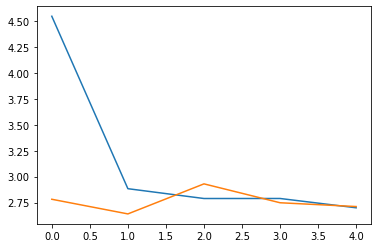

In [0]:
plt.plot(r.history['loss'], label = "train_loss")
plt.plot(r.history['val_loss'], label = "val_loss")

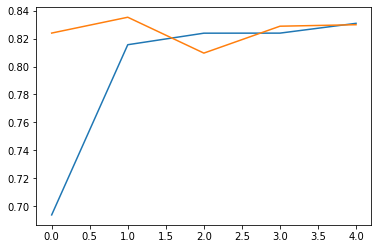

In [0]:
plt.plot(r.history['acc'], label = "train_accuracy")
plt.plot(r.history['val_acc'], label = "val_accuracy")

In [0]:
def get_confusion_matrix(gen, N):
  predictions = []
  targets = []
  i = 0
  for x, y in gen:
    i += 1
    p = model.predict(x)
    p = np.argmax(p, axis = 1)
    y = np.argmax(y, axis = 1)

    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))

    if len(targets) >= N:
      break
    
  cm = confusion_matrix(targets, predictions)
  return cm

In [0]:
test_cm = get_confusion_matrix(test_gen, len(test_files))
test_cm

array([[164,   0,   0,   0,   0,   0],
       [  0, 142,   0,   0,   1,   0],
       [  0,   0, 166,   0,   0,   0],
       [  0,   0,   0, 164,   0,   0],
       [  0,   0,   0,   0, 166,   0],
       [  0, 153,   7,   4,   0,   0]])

In [0]:
# with one extra dense layers with 1000 neurons
test_cm = get_confusion_matrix(test_gen, len(test_files))
test_cm

array([[164,   0,   0,   0,   0,   0],
       [  0, 122,   1,   0,  20,   0],
       [  0,   0, 166,   0,   0,   0],
       [139,   0,  21,   0,   4,   0],
       [  0,   0,   0,   0, 166,   0],
       [  0,   0,   0,   0,   0, 164]])